# Valley analysis in LSDTopoTools

Wlecome to `plot-valley-analysis`! In order to run this notebook you need to have followed the installation instructions on the `lsdtt-notebooks` GitHub repository and make sure you have `lsdviztools` installed. This notebook plots the results of the LSDTopoTools valley analysis code. It will produce map plots of the valley defined from LSDTT. It also has a number of different options depending on what you're interested in doing. 

If you chose to run the terrace extraction it will make:
* Separate map plots of the floodplain and the terraces

If you chose to measure valley width it will make:
* Plots of the valley width vs distance downstream
* Map plots of the valley width measurements

**NOTE: This is a work in progress!** 

------------------------------------------------------

**If you use this code please cite**: Clubb, F. J., Mudd, S. M., Milodowski, D. T., Valters, D. A., Slater, L. J., Hurst, M. D., and Limaye, A. B.: Geomorphometric delineation of floodplains and terraces from objectively defined topographic thresholds, Earth Surf. Dynam., 5, 369–385, https://doi.org/10.5194/esurf-5-369-2017, 2017.

------------------------------------------------------

## Package imports and declaring variables

Import required packages and define the data directory and DEM name here.

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import os

# import some lsdtt modules
# import lsdviztools.lsdbasemaptools as bmt
# from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
# import lsdviztools.lsdmapwrappers as lsdmw
# import lsdttparamselector as ps

Let's define the data directory and the prefix of your DEM. **The path to the folder MUST have a '/' at the end.**

In [ ]:
DataDirectory = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/Birs_Test11_180621/'
Base_file = "Birs_T11_Clipped"

## Valley plotting

This section makes map plot of the valley. First we'll read in the valley raster and make a plot against the shaded relief.

**NOTE: this is commented out at the moment due to issues with pip version of lsdviztools**

In [ ]:
# %matplotlib inline
# Drape_prefix = Base_file+"_valley"
# valley_img = lsdmw.BinaryDrape(DataDirectory,Base_file, Drape_prefix, cmap = "GnBu_r", alpha=1, save_fig=True)

## Valley width

In this section we'll make some plots of the valley width against distance.

In [ ]:
# Read in the valley width geojson
widths = gpd.read_file(DataDirectory+Base_file+'_valley_widths.geojson')
widths = widths[widths['total_valley_width'] > 0]

In [ ]:
# get the mean valley width
mean_width = widths['total_valley_width'].mean()

In [ ]:
# plot the raw width data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['distance_from_outlet'], widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance from outlet (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

In [ ]:
# make a plot of the rolling average of widths

In [ ]:
reach_length = 100    # set the reach length to average over in metres
widths['rolling_width'] = widths.rolling(reach_length, center=True).mean()['total_valley_width']
widths['rolling_width_std'] = widths.rolling(reach_length, center=True).std()['total_valley_width']

In [ ]:
# plot the rolling width data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['distance_from_outlet'], widths['total_valley_width'], c='0.5', lw=2, alpha=0.5)
ax.plot(widths['distance_from_outlet'], widths['rolling_width'], c='k', lw=2)
ax.axhline(mean_width, ls='--', c='red')
ax.set_xlabel('Distance from outlet (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

In [ ]:
widths

## Plotting a single reach along the valley centreline
This section is useful if you have run the code in tiles and want to make a composite plot of the valley width along the full valley. You will need a merged centreline of the valley as a line shapefile.

In [ ]:
# Read in the valley width geojson
widths = gpd.read_file(DataDirectory+Base_file+'_valley_widths.geojson')
widths = widths[widths['total_valley_width'] > 0]

In [ ]:
# name and path of the merged centreline
centreline_shp = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/Birs_valley_centreline_final.shp'
# the UTM EPSG code of your region. You need to set this so we can get the correct distances in metres.
UTM_EPSG_code = 'epsg:32632'

In [30]:
# now read in the centreline to a geopandas geodataframe
centreline = gpd.read_file(centreline_shp)

# get the centreline in UTM
centreline_utm = centreline.to_crs(UTM_EPSG_code)
# set up the pyproj transformer
transformer = Transformer.from_crs("epsg:4326", UTM_EPSG_code)

<GeometryArray>
Length: 1, dtype: geometry


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

In [ ]:
# get the distance of the widths along the line
def get_distance_along_line(row):
    #point = Point(row['longitude'], row['latitude'])
    # convert the point to UTM
    point = Point(transformer.transform(row['latitude'], row['longitude']))
    # getting the distance of the point along the line
    distance = centreline_utm.project(point)
    return(distance)
    
widths['centreline_dist'] = widths.apply(get_distance_along_line, axis=1)

In [ ]:
# make a plot of the valley width vs. distance along the merged centreline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['centreline_dist'], widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance along valley centreline (m)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()

## Plotting all the reaches along the valley centreline
In this section we will loop through all the directories in your subfolder and make a composite plot of the widths for each one.

In [31]:
# define the name of the base directory that you want to loop through
base_dir = '/media/TopographicData/TopographicData/valley_width/Switzerland/Birs/Valley_Centreline/'
# the name of the centreline shapefile - I am assuming it is located in the base directory
centreline_shp = base_dir+'Birs_valley_centreline_final.shp'
# the UTM EPSG code of your region. You need to set this so we can get the correct distances in metres.
UTM_EPSG_code = 'epsg:32632'

In [32]:
# now read in the centreline to a geopandas geodataframe
centreline = gpd.read_file(centreline_shp)
centreline = centreline.dissolve()

# get the centreline in UTM
centreline_utm = centreline.to_crs(UTM_EPSG_code)
# set up the pyproj transformer
transformer = Transformer.from_crs("epsg:4326", UTM_EPSG_code)

# set up the master dataframe for storing all the width data together
widths = gpd.GeoDataFrame()

In [33]:
centreline

,geometry,path,begin,end
0,"MULTILINESTRING ((7.21785 47.23365, 7.21787 47...",Birs_T10_centreline_nodes.shp|layername=Birs_T...,2302570.0,9203750.0


In [34]:
# get the distance of the widths along the line. This just defines the code that will do this, but won't actually
# do anything until the next block.
def get_distance_along_line(row):
    #point = Point(row['longitude'], row['latitude'])
    # convert the point to UTM
    point = Point(transformer.transform(row['latitude'], row['longitude']))
    # getting the distance of the point along the line
    distance = centreline_utm.project(point)
    return(distance)

In [35]:
# loop through the subdirectories and read in the valley width geojsons, calculate the distance along the centreline
# and write to a new geodataframe. This might be slow!
for root, subdirs, files in os.walk(base_dir):
    for file in files:
        if '_valley_widths.geojson' in file:
            this_gdf = gpd.read_file(os.path.join(root,file))
            this_gdf = this_gdf[this_gdf['total_valley_width'] > 0]
            this_gdf = this_gdf.drop(columns=['distance_from_outlet', 'node'])
            this_gdf['centreline_dist'] = this_gdf.apply(get_distance_along_line, axis=1)
            widths = widths.append(this_gdf, ignore_index=True)

In [36]:
widths

,latitude,longitude,flow_bearing,left_valley_width,orthogonal_bearing,right_valley_width,total_valley_width,geometry,centreline_dist
0,47.315008,7.390713,176.829880,73.089943,266.829895,10.997279,86.071678,"LINESTRING (7.39071 47.31501, 7.39074 47.31503)",22724.665777
1,47.315026,7.390739,165.472702,92.122261,255.472702,11.646230,105.747185,"LINESTRING (7.39074 47.31503, 7.39077 47.31504)",22724.668105
2,47.315045,7.390765,157.500000,173.885529,247.500000,14.228026,190.110809,"LINESTRING (7.39077 47.31504, 7.39076 47.31506)",22724.651932
3,47.315063,7.390764,150.338623,41.179859,240.338623,15.120774,58.295101,"LINESTRING (7.39076 47.31506, 7.39074 47.31506)",22726.088238
4,47.315062,7.390738,148.282532,39.487148,238.282532,13.418885,54.904541,"LINESTRING (7.39074 47.31506, 7.39071 47.31508)",22727.490637
...,...,...,...,...,...,...,...,...,...
10557,47.331105,7.376914,330.186523,26.778576,60.186523,42.898884,71.676895,"LINESTRING (7.37691 47.33111, 7.37691 47.33112)",25461.364342
10558,47.331123,7.376913,328.696777,27.837849,58.696777,39.487606,69.323402,"LINESTRING (7.37691 47.33112, 7.37689 47.33114)",25463.377747
10559,47.331141,7.376886,326.021362,27.837849,56.021362,37.824062,67.659744,"LINESTRING (7.37689 47.33114, 7.37686 47.33116)",25466.162111
10560,47.331158,7.376859,326.021362,29.521715,56.021362,37.824062,69.323402,"LINESTRING (7.37686 47.33116, 7.37683 47.33118)",25468.998550


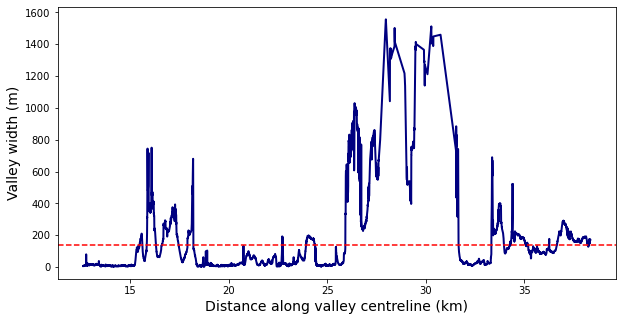

In [39]:
# sort by the distance along the centreline to make sure we're plotting in the right order
widths = widths.sort_values(by='centreline_dist')

# get the mean valley width
mean_width = widths['total_valley_width'].mean()

# make a plot of the valley width vs. distance along the merged centreline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(widths['centreline_dist']/1000, widths['total_valley_width'], c='navy', lw=2)
ax.axhline(mean_width, ls='--', c='r')
ax.set_xlabel('Distance along valley centreline (km)', fontsize=14)
ax.set_ylabel('Valley width (m)', fontsize=14)
plt.show()